# Spotify Genre Classification - Data exploration

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade --user --quiet
# !pip install numpy --upgrade --user --quiet
# !pip install scipy --upgrade --user --quiet
# !pip install statsmodels --upgrade --user --quiet
# !pip install scikit-learn --upgrade --user --quiet
# !pip install --upgrade --quiet pillow
# !pip install --upgrade --quiet scikit-learn
# !pip install --upgrade --quiet lime
# !pip install missingno

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA
from IPython.core.display import display, HTML
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.colors as mcolors
import missingno as msno
from sklearn.preprocessing import MultiLabelBinarizer



show_html = lambda html: display(HTML(html))

import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.precision', 3)
palette = sns.color_palette("Greens_d", 10)

colors = mcolors._colors_full_map
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(color)[:3])), name)
                for name, color in colors.items())
sorted_names = [name for hsv, name in by_hsv]

sns.set_color_codes("colorblind")
pal = sns.color_palette("Greys")
sns.set()

## Data exploration

In [3]:
data = pd.read_csv("./data/genres_v2.csv")
data = data.round(4)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42305 entries, 0 to 42304
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      42305 non-null  float64
 1   energy            42305 non-null  float64
 2   key               42305 non-null  int64  
 3   loudness          42305 non-null  float64
 4   mode              42305 non-null  int64  
 5   speechiness       42305 non-null  float64
 6   acousticness      42305 non-null  float64
 7   instrumentalness  42305 non-null  float64
 8   liveness          42305 non-null  float64
 9   valence           42305 non-null  float64
 10  tempo             42305 non-null  float64
 11  type              42305 non-null  object 
 12  id                42305 non-null  object 
 13  uri               42305 non-null  object 
 14  track_href        42305 non-null  object 
 15  analysis_url      42305 non-null  object 
 16  duration_ms       42305 non-null  int64 

In [5]:
data.nunique()

danceability          845
energy                895
key                    12
loudness            11360
mode                    2
speechiness          1391
acousticness         1856
instrumentalness     1784
liveness             1640
valence              1620
tempo               15447
type                    1
id                  35877
uri                 35877
track_href          35877
analysis_url        35877
duration_ms         26261
time_signature          4
genre                  15
song_name           15439
Unnamed: 0          20780
title                 132
dtype: int64

## Basic data cleaning

In [6]:
data = data.drop(columns=['Unnamed: 0','title','song_name', 'type','uri','track_href','analysis_url'])
data.shape

(42305, 15)

## Before pre-processing

In [7]:
numerical = ['danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
    'duration_ms']
categorical = ['id','genre', 'key','mode', 'time_signature']

balanced target?

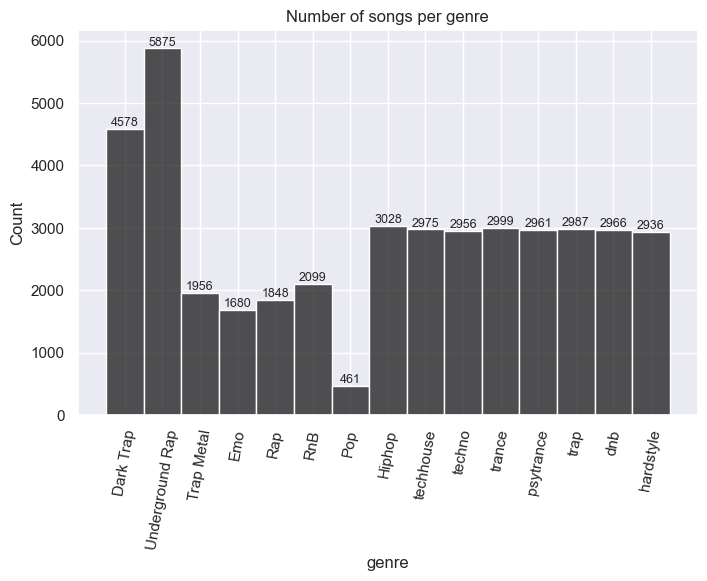

In [8]:
labels = data.genre.unique()
fig,ax2 = plt.subplots(1, figsize=(8,5))

sns.histplot(data["genre"], color="k")
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=80)
t2 = ax2.set_title('Number of songs per genre')
# show count (+ annotate)
for rect in ax2.patches:
    ax2.text (rect.get_x() + rect.get_width()  / 2,rect.get_height()+50,rect.get_height(),horizontalalignment='center', fontsize = 9)

plt.show();

how are the features relationed to the target?

In [9]:
data.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'id', 'duration_ms', 'time_signature', 'genre'],
      dtype='object')

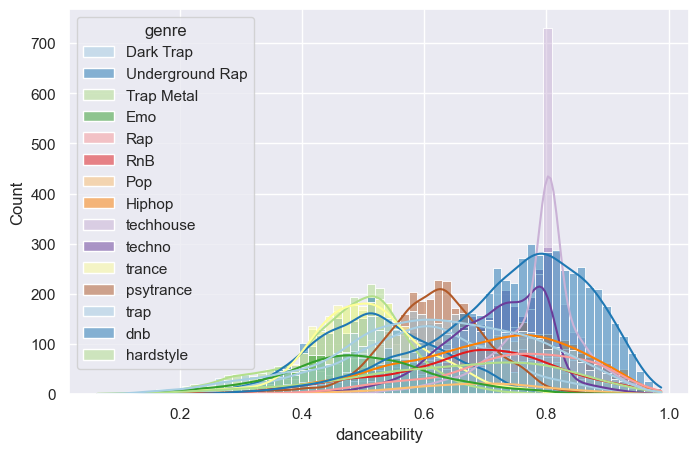

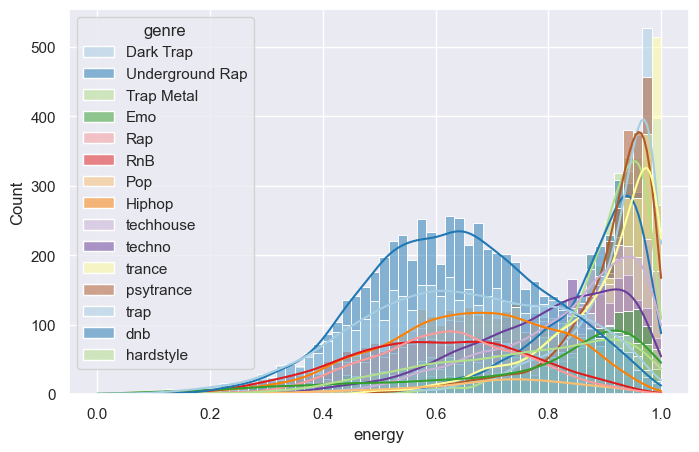

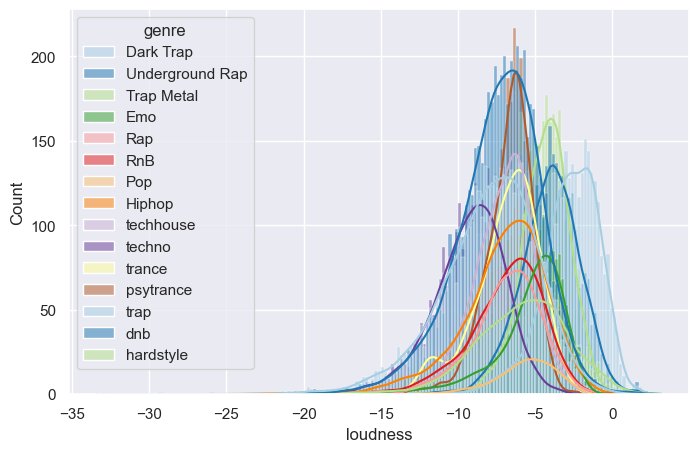

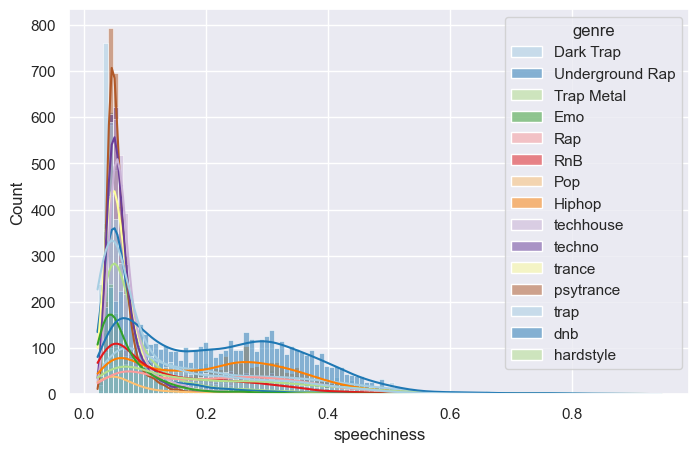

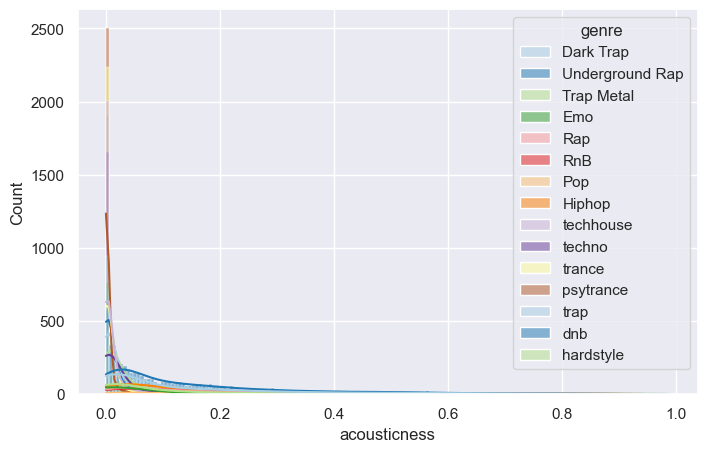

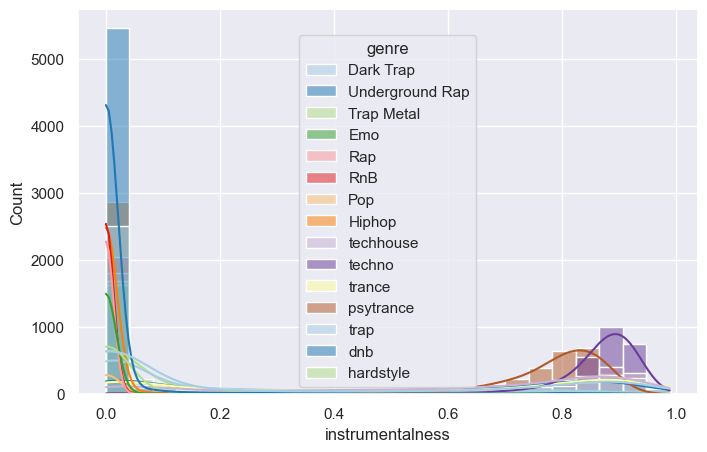

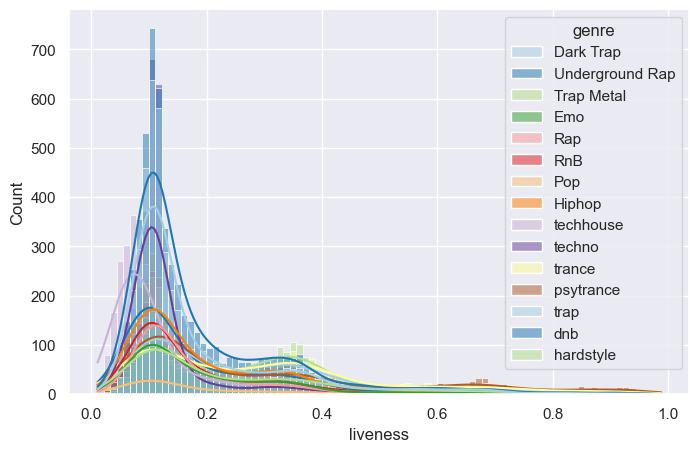

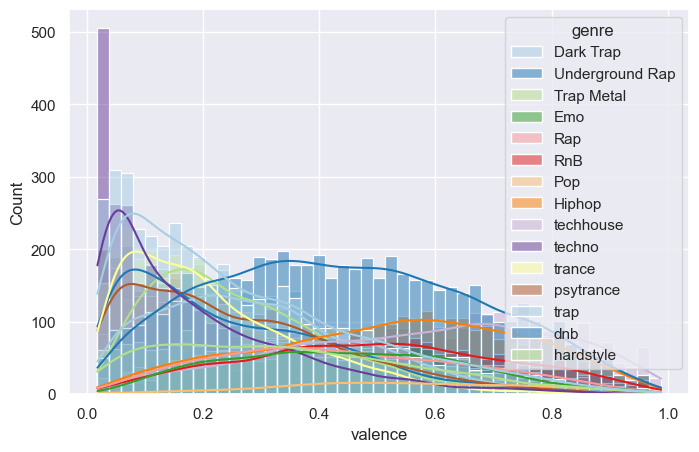

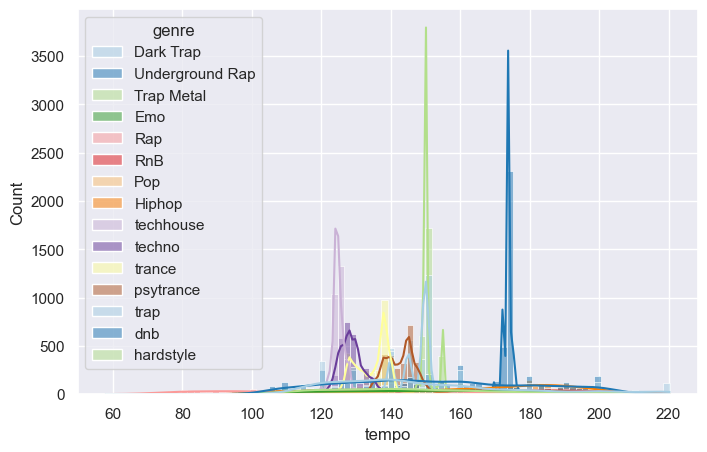

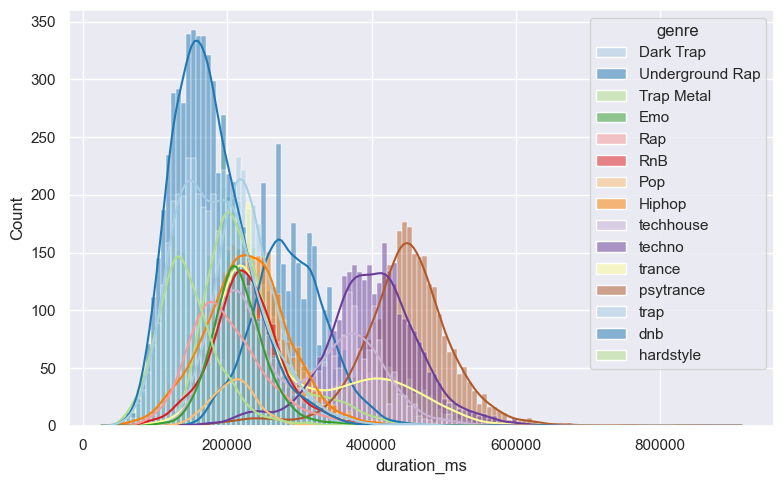

In [10]:
for i,c in enumerate(numerical):
    fig, axes= plt.subplots(1, figsize=(8,5))
    sns.histplot(hue ='genre', x = c, data = data, ax = axes, kde = True, palette=sns.color_palette("Paired"))
    
plt.tight_layout()

## Pre-processing

### Duplicated values

We remove the global duplicates, but there were still duplicate id tracks.

In [11]:
data = data.drop_duplicates()

We visualize the tracks that contain a duplicated id.

In [12]:
id_dupl = data[data['id'].duplicated(keep=False) == True].sort_values("id")
id_dupl

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
2305,0.853,0.726,3,-7.414,0,0.0728,0.3620,0.0003,0.1100,0.821,136.073,00RaykzZO1vFk3eSSxHYHV,140251,4,Dark Trap
4625,0.853,0.726,3,-7.414,0,0.0728,0.3620,0.0003,0.1100,0.821,136.073,00RaykzZO1vFk3eSSxHYHV,140251,4,Underground Rap
11399,0.853,0.726,3,-7.414,0,0.0728,0.3620,0.0003,0.1100,0.821,136.073,00RaykzZO1vFk3eSSxHYHV,140251,4,Trap Metal
1362,0.583,0.915,4,-2.191,1,0.4640,0.0936,0.0000,0.3480,0.628,179.836,00bEP3V5Ova0ihFnLUFbK2,138757,4,Dark Trap
11862,0.583,0.915,4,-2.191,1,0.4640,0.0936,0.0000,0.3480,0.628,179.836,00bEP3V5Ova0ihFnLUFbK2,138757,4,Trap Metal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,0.732,0.625,1,-11.517,0,0.2820,0.0138,0.0001,0.7030,0.196,134.922,7zSGKAncFa0CeZ5N6ZQqNm,142310,4,Underground Rap
1363,0.655,0.948,8,-4.338,1,0.4160,0.4620,0.0000,0.0835,0.690,159.897,7zShdWNBUXsUoU3akjRVHW,108004,4,Dark Trap
11905,0.655,0.948,8,-4.338,1,0.4160,0.4620,0.0000,0.0835,0.690,159.897,7zShdWNBUXsUoU3akjRVHW,108004,4,Trap Metal
8781,0.646,0.709,5,-6.005,0,0.0381,0.0092,0.0003,0.1150,0.281,161.008,7zkLlx4bTeeyUyzs1L7gV4,159150,4,Underground Rap


To look the differences between track ids, we do a group by of id, and those that values that differs we put a NaN else its value.

In [13]:
ids_dupl = id_dupl.groupby('id', as_index=False).agg(lambda x: x.iloc[0] if x.nunique()==1 else np.nan)
ids_dupl

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,00RaykzZO1vFk3eSSxHYHV,0.853,0.726,3,-7.414,0,0.0728,0.3620,0.0003,0.1100,0.821,136.073,140251,4,NaN
1,00bEP3V5Ova0ihFnLUFbK2,0.583,0.915,4,-2.191,1,0.4640,0.0936,0.0000,0.3480,0.628,179.836,138757,4,NaN
2,00ko9WaS4jOX1kEk3gvHjf,0.899,0.509,9,-8.040,1,0.3870,0.0016,0.0000,0.0573,0.599,150.001,225924,4,NaN
3,00p85inzGeXRXgqDVn7Ftq,0.756,0.453,8,-9.965,1,0.3180,0.0039,0.0000,0.6320,0.114,140.132,144380,4,NaN
4,00povvAoXqjwRmQeO4NrCu,0.814,0.952,8,-7.037,0,0.0655,0.0052,0.9150,0.0383,0.687,125.005,403054,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2515,7zL9xrz5krsuC6qVNluQQw,0.800,0.633,8,-4.875,0,0.0514,0.0901,0.0000,0.0315,0.836,191.906,203360,4,NaN
2516,7zLYKWcXnYeHHWidalz7rj,0.699,0.558,11,-7.622,1,0.0603,0.4620,0.0000,0.1160,0.493,NaN,165000,4,NaN
2517,7zSGKAncFa0CeZ5N6ZQqNm,0.732,0.625,1,-11.517,0,0.2820,0.0138,0.0001,0.7030,0.196,134.922,142310,4,NaN
2518,7zShdWNBUXsUoU3akjRVHW,0.655,0.948,8,-4.338,1,0.4160,0.4620,0.0000,0.0835,0.690,159.897,108004,4,NaN


The number of differences can be seen in the cell bellow. Remember: the different values were seted as NaN.

In [14]:
ids_dupl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2520 entries, 0 to 2519
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2520 non-null   object 
 1   danceability      2519 non-null   float64
 2   energy            2520 non-null   float64
 3   key               2520 non-null   int64  
 4   loudness          2520 non-null   float64
 5   mode              2520 non-null   int64  
 6   speechiness       2518 non-null   float64
 7   acousticness      2519 non-null   float64
 8   instrumentalness  2520 non-null   float64
 9   liveness          2520 non-null   float64
 10  valence           2518 non-null   float64
 11  tempo             2201 non-null   float64
 12  duration_ms       2520 non-null   int64  
 13  time_signature    2520 non-null   int64  
 14  genre             0 non-null      float64
dtypes: float64(10), int64(4), object(1)
memory usage: 295.4+ KB


<Axes: >

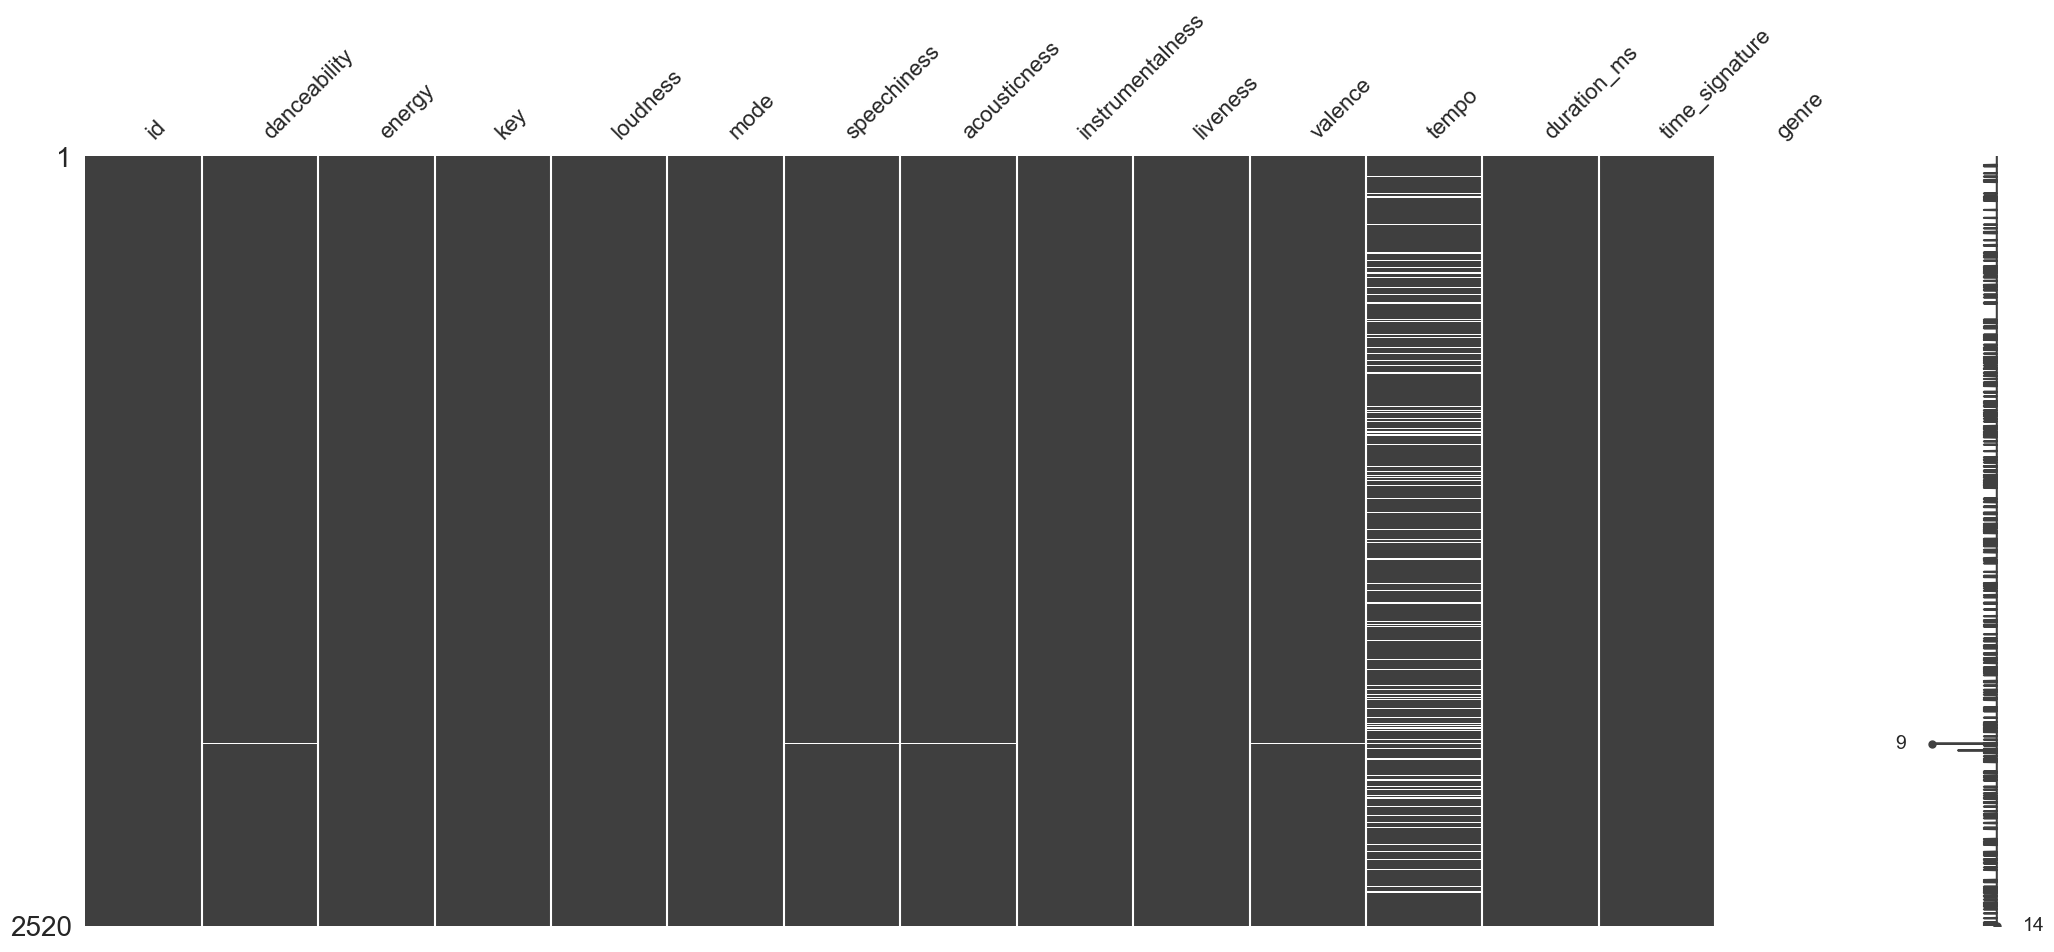

In [15]:
msno.matrix(ids_dupl)

Here we summarise the rows that contain most differences between the same id tracks. Genres is in white, that means that all these ids (tracks/songs) are associated to different genres. Moreover, in `id_dupl`we can see that the differences in all the features (no genre) were minimal, possibly due to overflow.

In [16]:
#data[data['id'] == '65ES1qwOB577ZnTkizMXJJ']
data[data['id'] == '697MjF1454XKvZmTuqkWmD']

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
18211,0.52,0.789,0,-7.717,1,0.0433,0.0049,0.0,0.0816,0.416,174.038,697MjF1454XKvZmTuqkWmD,216347,4,Pop
38335,0.52,0.789,0,-7.717,1,0.0432,0.0049,0.0,0.0816,0.415,174.026,697MjF1454XKvZmTuqkWmD,216347,4,dnb


However,  I think it is worth to mention that all tracks with genre `hardstyle`, only have a single genre associated.

In [17]:
a = id_dupl['genre'].unique()
b = data['genre'].unique() 
np.setdiff1d(b,a)

array(['hardstyle'], dtype=object)

As we want to do a multi-class classification, we proceed to eliminate duplicate tracks manually, in such a way that if a track has associated Pop (class with few instances) and Trap (class with many instances), we would be left with the one of the minority class, in this case Pop, and the association of Trap would be removed. In this way, we also reduce the unbalancing of our target.

In [18]:
def test(xs):
    genre = {}
    for x in xs:
        genre[x] = int(data['genre'].value_counts()[x])
    return min(genre, key=genre.get)

In [19]:
multilabel = data.copy() # saving the data in order to use it for Multi-Label classifiaction
b = data.groupby('id').genre.apply(test)
data= pd.merge(data, b, how='inner', on=['id','genre'])

### Missing values

We use the `dropna()`function, but as we can does nothing.

In [20]:
print(f"previous shape: {data.shape}")
data = data.dropna()
print(f"current shape: {data.shape}") # does nothing!

previous shape: (35877, 15)
current shape: (35877, 15)


We check also the missing values with the `isnull()`, but no null values found any

In [21]:
data.isnull().sum()

danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
id                  0
duration_ms         0
time_signature      0
genre               0
dtype: int64

So, we proceed to explore if there are hidden missing value. We found that under the value of 0 could be some hidden missing value. However, reading the features report we decided to remain it all as it was.

In [22]:
data2 = data.copy()
for i,c in enumerate(data2.columns):
  data2[c][data2[c] == 0] = np.nan
data2.isnull().sum()

danceability            0
energy                  0
key                  2963
loudness                1
mode                16251
speechiness             0
acousticness         1189
instrumentalness    13133
liveness                0
valence                 0
tempo                   0
id                      0
duration_ms             0
time_signature          0
genre                   0
dtype: int64

Text(0.5, 1.0, 'Quantifying of zeros values')

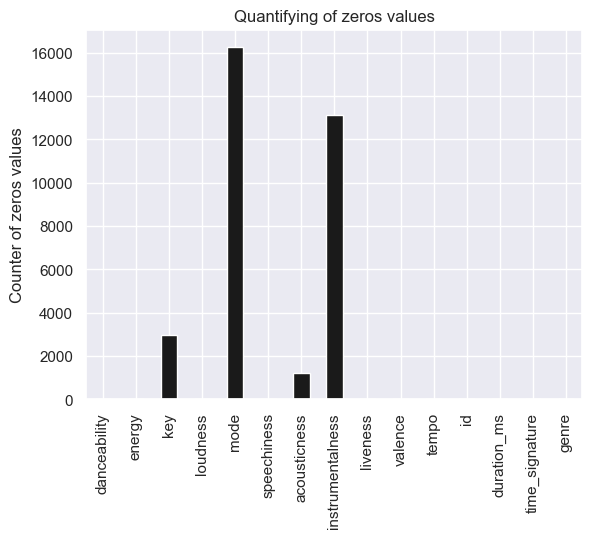

In [23]:
data2.isnull().sum().plot.bar( color="k")
plt.ylabel('Counter of zeros values')
plt.title('Quantifying of zeros values')

### Incoherent values

Looking to the statiscal report of our attributes. We found that loudness exceeds the range of value which is normal, meaning that is noise. Therefore, we decided to remove it.

In [24]:
data.loudness[data['loudness'] > 0] = np.nan
data.isnull().sum()

danceability          0
energy                0
key                   0
loudness            166
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
id                    0
duration_ms           0
time_signature        0
genre                 0
dtype: int64

In [25]:
data.dropna(inplace=True)
data.shape

(35711, 15)

### Outliers

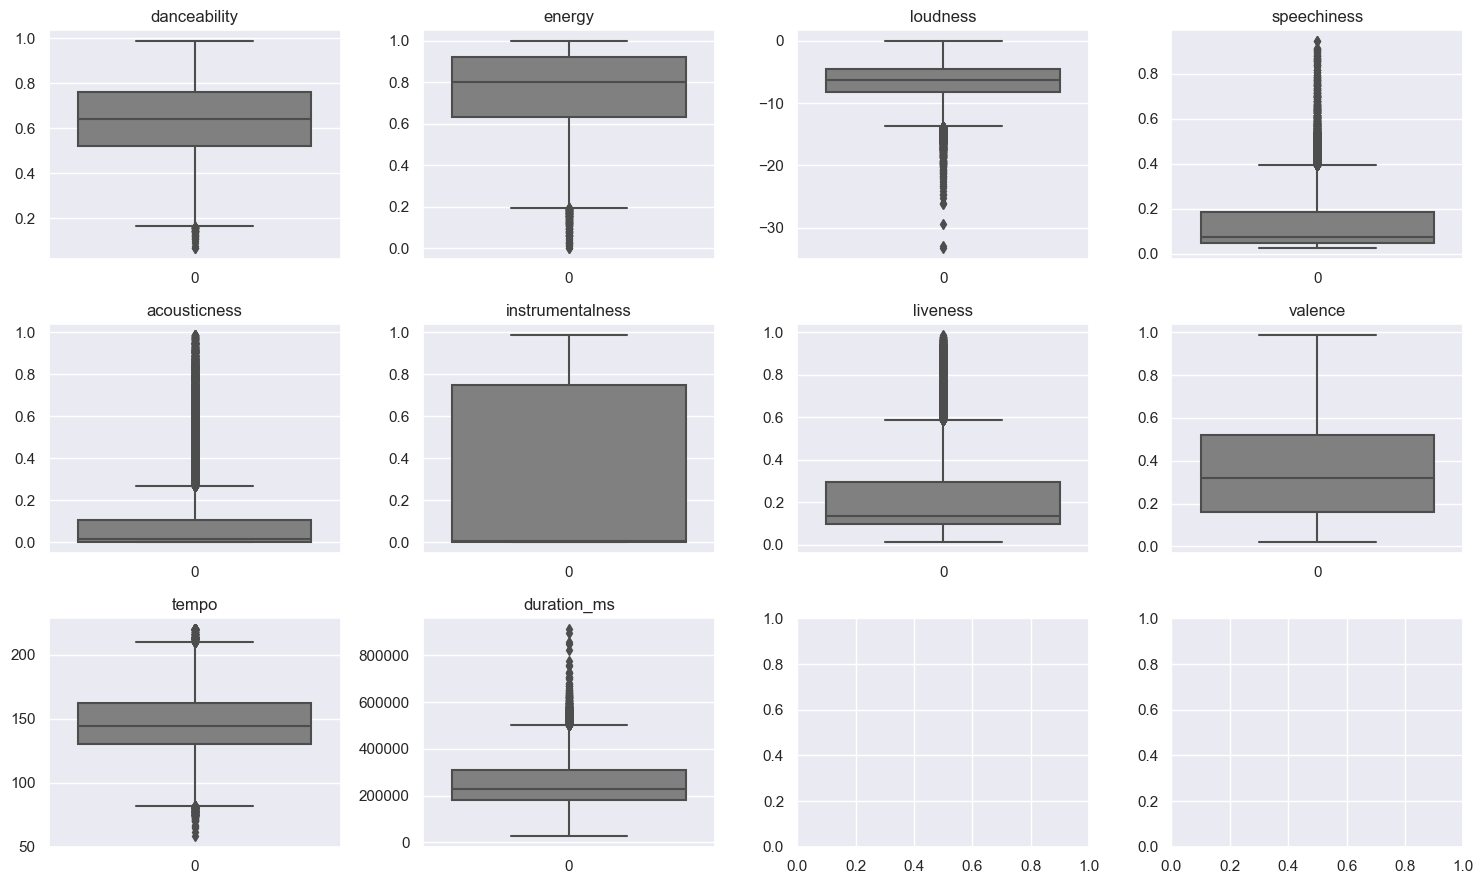

In [26]:
# Box plots 
fig, axes = plt.subplots(3,4,figsize=(15,9))
for i, c in enumerate(numerical):
    ax = axes.reshape(-1)[i]
    sns.boxplot(data[c],ax=ax, color=sorted_names[8])

    t = ax.set_title(c)
plt.tight_layout()

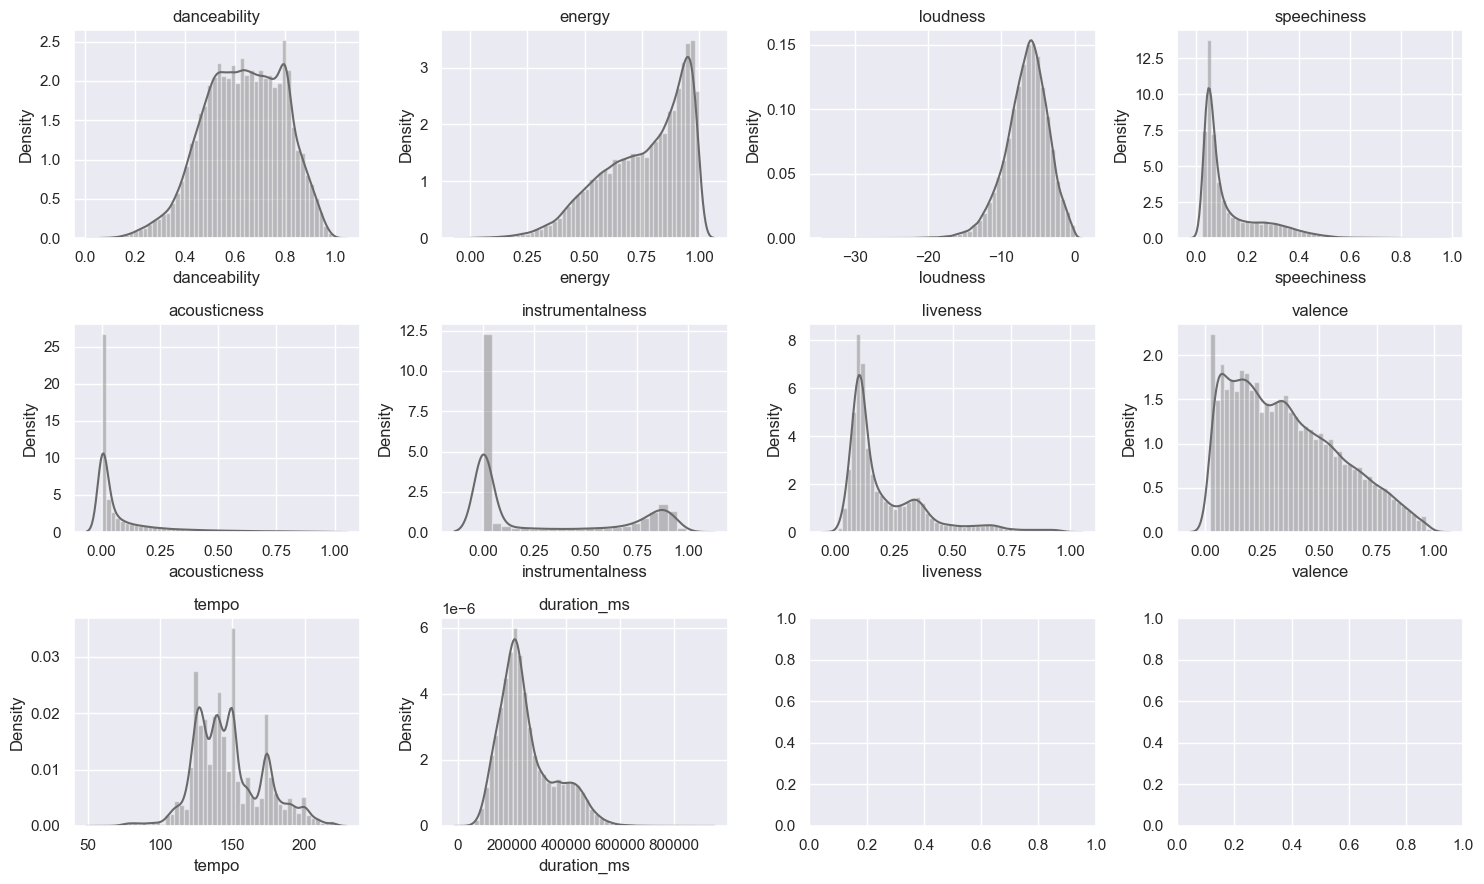

In [27]:
# Distribution plots
fig, axes = plt.subplots(3,4,figsize=(15,9))
for i, c in enumerate(numerical):
    ax = axes.reshape(-1)[i]
    sns.distplot(data[c],ax=ax, color=sorted_names[3])

    t = ax.set_title(c)
plt.tight_layout()

## Visualization

In [28]:
data.drop('id',axis='columns',inplace = True)
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
features = data.columns[:-1]

In [37]:
X_standarized = data.copy()
X_standarized[features] = StandardScaler().fit_transform(X)
X_standarized.describe()

myPCA = PCA()
myPCA.fit(X_standarized[features])
print(myPCA.explained_variance_ratio_)
print(myPCA.explained_variance_ratio_.cumsum())


[0.20147872 0.14776255 0.10187681 0.09591279 0.0747967  0.0717464
 0.06546276 0.05643907 0.05520604 0.04780586 0.0357051  0.02985755
 0.01594966]
[0.20147872 0.34924127 0.45111808 0.54703087 0.62182757 0.69357397
 0.75903673 0.8154758  0.87068184 0.91848769 0.95419279 0.98405034
 1.        ]


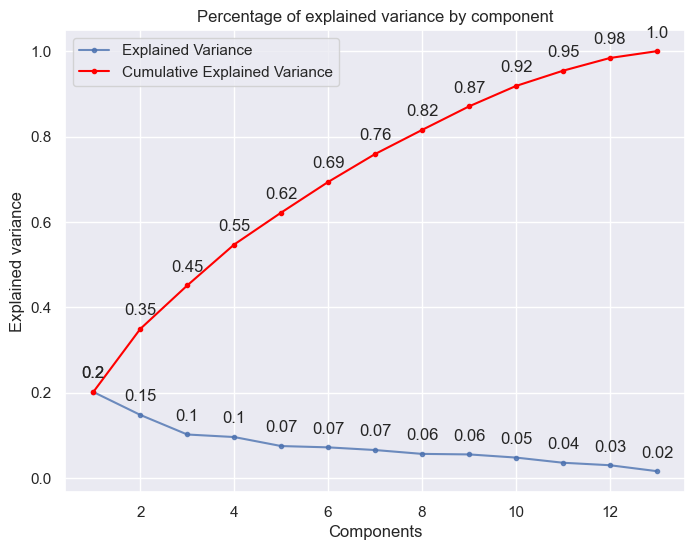

In [38]:

fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),myPCA.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Explained Variance");
y_label = plt.ylabel('Explained variance');
x_label = plt.xlabel('Components');
plt.plot(range(1,len(myPCA.explained_variance_ratio_ )+1),
         np.cumsum(myPCA.explained_variance_ratio_),
         c='red',marker='.',
         label="Cumulative Explained Variance");

for x, y in zip(np.arange(len(features)) + 1, np.cumsum(myPCA.explained_variance_ratio_)):
    label = round(y, 2)
    plt.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
for x, y in zip(np.arange(len(features)) + 1,myPCA.explained_variance_ratio_):
    label = round(y, 2)
    plt.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
plt.legend();
plt.title('Percentage of explained variance by component');

In [33]:
pd.DataFrame(
    data    = myPCA.components_,
    columns = features,
    index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13']
)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
PC1,0.255403,-0.442096,-0.062658,-0.167611,0.051768,0.339131,0.373984,-0.430313,-0.130179,0.258352,0.116325,-0.408998,-0.008600
PC2,0.213626,-0.372978,0.036317,-0.576282,-0.010538,-0.231876,0.184161,0.336364,-0.278319,-0.193780,-0.300450,0.269900,-0.052621
PC3,-0.598456,-0.172354,0.081522,-0.107923,-0.225769,-0.120175,0.301316,-0.092979,0.113890,-0.480920,0.293379,-0.161475,-0.269446
PC4,-0.101999,-0.035627,-0.695306,-0.024252,0.663467,-0.028099,-0.021077,0.006340,0.072344,-0.210534,-0.013537,-0.031545,-0.109950
PC5,0.137830,0.081288,0.096526,0.031565,0.043890,0.059102,-0.035963,0.049470,0.058568,0.235209,-0.034568,0.080030,-0.942639
PC6,0.014030,-0.046575,0.098412,-0.189312,0.010201,0.221248,0.113052,0.000771,0.837815,-0.032537,-0.426838,-0.001200,0.071335
PC7,-0.073255,0.044759,-0.131682,0.239100,-0.210728,-0.255013,-0.030029,-0.267750,-0.219638,-0.121553,-0.726808,-0.367310,-0.099544
PC8,0.109477,-0.002752,-0.668593,-0.088673,-0.676384,0.143998,-0.083966,0.064305,0.097887,0.055156,0.105597,0.134107,-0.044192
PC9,0.092969,-0.029968,0.130340,-0.044298,-0.003748,0.662124,-0.430061,-0.012960,-0.199256,-0.543984,-0.075843,-0.042749,-0.069024
PC10,-0.251504,0.268221,-0.060702,0.193013,0.021588,0.450729,0.611587,0.143933,-0.249559,0.066954,-0.230391,0.322898,0.037152


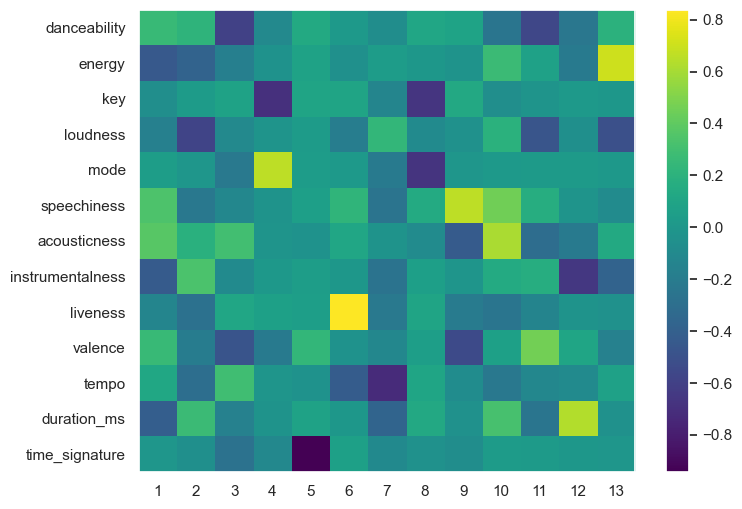

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
componentes = myPCA.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(features)), features)
plt.xticks(range(len(features)), np.arange(myPCA.n_components_) + 1)
plt.grid(False)
plt.colorbar();

In [43]:
correlation_mat = X.corr()
correlation_mat.style.background_gradient(cmap='viridis')

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
danceability,1.000000,-0.315377,-0.012555,-0.206006,0.076741,0.197439,0.061184,-0.070192,-0.197173,0.362158,-0.159227,-0.035689,0.059520
energy,-0.315377,1.000000,0.043764,0.598870,-0.030403,-0.156282,-0.504019,0.301966,0.234634,-0.018088,-0.020027,0.296527,0.040642
key,-0.012555,0.043764,1.000000,-0.008654,-0.249565,-0.033419,-0.007904,0.069550,0.002373,0.023327,-0.007271,0.068533,0.006768
loudness,-0.206006,0.598870,-0.008654,1.000000,-0.003007,0.033049,-0.288224,-0.191753,0.161771,0.099987,0.154268,-0.091282,0.046020
mode,0.076741,-0.030403,-0.249565,-0.003007,1.000000,0.048207,-0.010458,-0.017810,0.010073,0.021701,-0.009920,-0.027675,-0.009228
speechiness,0.197439,-0.156282,-0.033419,0.033049,0.048207,1.000000,0.164591,-0.389678,0.047466,0.236575,0.159441,-0.312973,0.019886
acousticness,0.061184,-0.504019,-0.007904,-0.288224,-0.010458,0.164591,1.000000,-0.261658,-0.108909,0.102119,0.055458,-0.251726,-0.054623
instrumentalness,-0.070192,0.301966,0.069550,-0.191753,-0.017810,-0.389678,-0.261658,1.000000,-0.008722,-0.284652,-0.204609,0.601672,-0.010334
liveness,-0.197173,0.234634,0.002373,0.161771,0.010073,0.047466,-0.108909,-0.008722,1.000000,-0.023547,0.026600,0.014879,0.000336
valence,0.362158,-0.018088,0.023327,0.099987,0.021701,0.236575,0.102119,-0.284652,-0.023547,1.000000,0.080423,-0.200353,0.039614


<Axes: xlabel='PC1', ylabel='PC2'>

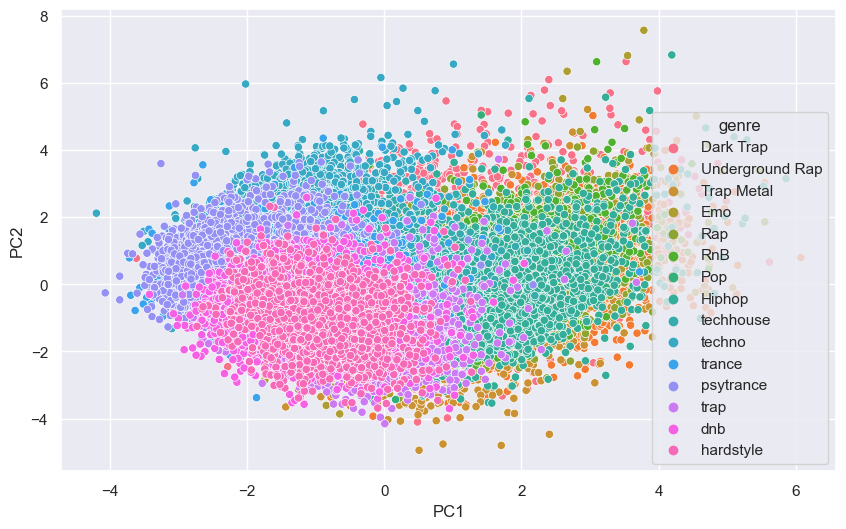

In [42]:
transformed_X = myPCA.transform(X_standarized[features])
X_standarized[['PC1','PC2', 'PC3','PC4','PC5','PC6']] = transformed_X[:,:6]
fig = plt.figure(figsize=(10,6))
sns.scatterplot(x='PC1', y='PC2', hue='genre', data=X_standarized)

## Train/Test split

In [46]:
def train_data():
    train = pd.read_csv('./spoty_train_multiclass.csv')
    y_train = train['genre']
    X_train = train.drop('genre',axis='columns')
    test = pd.read_csv('./spoty_test_multiclass.csv')
    y_test = test['genre']
    X_test = test.drop('genre',axis='columns')
    return X_train, X_test, y_train, y_test


In [49]:
train, test = train_test_split(data, test_size=0.3, random_state=0)

print(train.shape, test.shape)

train.to_csv('spoty_train_multiclass.csv', compression=None, index = False)
test.to_csv('spoty_test_multiclass.csv', compression=None, index = False)

(24997, 14) (10714, 14)


# Multi-label classification processing

We were not sure if we would manage to do it cause the time limitation we get, but  so as suggested to the teacher, we decided to try to explore the multi-label classification (new concept unseen in class).

We start to the point of duplicates, cause we need all the genres by id.


To implemet a function, to combine the genres, i.e the instances in order to have an unique track id, the genre will be groupped with an array if it has multiple genres associated.

Like this:
trackID1 + ['Pop','trap']

In [201]:
multilab = data.copy()
b = multilab.groupby('id',as_index=False).genre.apply(list)


,id,genre
0,001dY1wrXF0Vfo40Kkqv4R,[techno]
1,001rJKlws3dVKuURJQdnIk,[techno]
2,00349h1hy2raWiakxSDfsU,[trance]
3,003FTlCpBTM4eSqYSWPv4H,[Emo]
4,003VDDA7J3Xb2ZFlNx7nIZ,[Rap]
...,...,...
35872,7zrH5Yxm0GYeQAKyy4ctp5,[Hiphop]
35873,7zs4U1U5Rbj5k7nQ1vuuGF,[trap]
35874,7zw5QFPrerWf8XzZW70z3L,[RnB]
35875,7zxtj0SKcfBMYWnf7nYrsG,[Hiphop]


In [202]:
x = multilab.groupby('id',as_index=False).apply(lambda x: x.iloc[0])
x.drop(columns='genre', inplace = True)
df = x.merge(b,on='id')
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,duration_ms,time_signature,genre
0,0.779,0.755,11,-10.760,0,0.0519,0.0006,0.8930,0.0998,0.1410,137.012,001dY1wrXF0Vfo40Kkqv4R,354337,4,[techno]
1,0.770,0.886,1,-8.358,1,0.0426,0.0007,0.8740,0.1010,0.2870,124.996,001rJKlws3dVKuURJQdnIk,215040,4,[techno]
2,0.469,0.912,5,-7.610,0,0.0359,0.0022,0.8230,0.2790,0.0591,138.003,00349h1hy2raWiakxSDfsU,240005,4,[trance]
3,0.553,0.717,7,-5.857,1,0.0318,0.0001,0.1280,0.0385,0.3180,127.947,003FTlCpBTM4eSqYSWPv4H,233267,4,[Emo]
4,0.842,0.578,6,-6.050,0,0.1380,0.0042,0.0000,0.2280,0.1900,74.496,003VDDA7J3Xb2ZFlNx7nIZ,236779,4,[Rap]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35872,0.614,0.713,1,-4.213,1,0.1520,0.2960,0.0000,0.3670,0.6370,170.095,7zrH5Yxm0GYeQAKyy4ctp5,183572,4,[Hiphop]
35873,0.731,0.888,1,-5.105,1,0.3040,0.0019,0.0205,0.1710,0.5880,142.117,7zs4U1U5Rbj5k7nQ1vuuGF,325352,4,[trap]
35874,0.772,0.673,4,-6.082,0,0.2400,0.2730,0.0000,0.4750,0.7780,119.971,7zw5QFPrerWf8XzZW70z3L,281187,4,[RnB]
35875,0.729,0.567,9,-7.333,1,0.1540,0.3530,0.0000,0.2360,0.3430,130.942,7zxtj0SKcfBMYWnf7nYrsG,169587,4,[Hiphop]


In [204]:
mlb = MultiLabelBinarizer()
df = df.join(pd.DataFrame(mlb.fit_transform(df['genre']),columns=mlb.classes_))
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,RnB,Trap Metal,Underground Rap,dnb,hardstyle,psytrance,techhouse,techno,trance,trap
0,0.779,0.755,11,-10.760,0,0.0519,0.0006,0.8930,0.0998,0.1410,...,0,0,0,0,0,0,0,1,0,0
1,0.770,0.886,1,-8.358,1,0.0426,0.0007,0.8740,0.1010,0.2870,...,0,0,0,0,0,0,0,1,0,0
2,0.469,0.912,5,-7.610,0,0.0359,0.0022,0.8230,0.2790,0.0591,...,0,0,0,0,0,0,0,0,1,0
3,0.553,0.717,7,-5.857,1,0.0318,0.0001,0.1280,0.0385,0.3180,...,0,0,0,0,0,0,0,0,0,0
4,0.842,0.578,6,-6.050,0,0.1380,0.0042,0.0000,0.2280,0.1900,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35872,0.614,0.713,1,-4.213,1,0.1520,0.2960,0.0000,0.3670,0.6370,...,0,0,0,0,0,0,0,0,0,0
35873,0.731,0.888,1,-5.105,1,0.3040,0.0019,0.0205,0.1710,0.5880,...,0,0,0,0,0,0,0,0,0,1
35874,0.772,0.673,4,-6.082,0,0.2400,0.2730,0.0000,0.4750,0.7780,...,1,0,0,0,0,0,0,0,0,0
35875,0.729,0.567,9,-7.333,1,0.1540,0.3530,0.0000,0.2360,0.3430,...,0,0,0,0,0,0,0,0,0,0


Now we did  the preprocess we did it in multiclass classification.